# Indian Liver Patient Records

Use supervised learning on the Indian patient records to determine which patients have liver disease. The data is from Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science. There are a number of machine learning papers that work on this data set;for example:
- Bendi Venkata Ramana, Prof. M. S. Prasad Babu and Prof. N. B. Venkateswarlu, "A Critical Comparative Study of Liver Patients from USA and INDIA: An Exploratory Analysis", International Journal of Computer Science Issues, (May 2012)
- Bendi Venkata Ramana and Prof. M.Surendra Prasad Babu, "Liver Classification Using Modified Rotation Forest" International Journal of Engineering Research and Development,  (June 2012)

## Outline <a id='outline'></a>

1. [Exploring data](#Exploringdata): 
     - Find missing data, and turn string data into catergory
     - Inspect the number of patients with and without liver disease among [age and gender groups](#genderage)
    
2. [Logistic Regression](#LG): 
     - [Hyperparameter tuning](#LG_hyper)
     - [Feature of importance](#LG_feature)
     - [Results](#LG_result): confusion matrix, most correct and most incorrect predictions for each class
     
3. [Conclusions](#con): 

In [29]:
#import packages
import sys
from pathlib import Path
sys.path.append(r'C:\Users\Benny\fastai\old')
#sys.path.append(r'C:\Users\Benny\Anaconda3\envs\fastai\Lib\site-packages\graphviz')

%config IPCompleter.greedy=True
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from fastai.io import *
from fastai.dataset import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (classification_report, confusion_matrix,
accuracy_score, log_loss)

from IPython.display import display
import seaborn as sns
plt.style.use('ggplot')

import feather

## Exploring data <a id='Exploringdata'></a>

In [3]:
df_raw=pd.read_feather('tmp/liver_patient_raw')
df_raw.head().T

,0,1,2,3,4
Age,65,62,62,58,72
Gender,Female,Male,Male,Male,Male
Total_Bilirubin,0.7,10.9,7.3,1,3.9
Direct_Bilirubin,0.1,5.5,4.1,0.4,2
Alkaline_Phosphotase,187,699,490,182,195
Alamine_Aminotransferase,16,64,60,14,27
Aspartate_Aminotransferase,18,100,68,20,59
Total_Protiens,6.8,7.5,7,6.8,7.3
Albumin,3.3,3.2,3.3,3.4,2.4
Albumin_and_Globulin_Ratio,0.9,0.74,0.89,1,0.4


In [4]:
#Convert the Dataset columns into strings.
df_raw['Dataset'].replace({1:'ill',2:'healthy'}, inplace=True)
# converts all string columns into catergory
train_cats(df_raw)

In [5]:
df_raw['Dataset'].cat.categories

Index(['healthy', 'ill'], dtype='object')

In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
Age                           583 non-null int64
Gender                        583 non-null category
Total_Bilirubin               583 non-null float64
Direct_Bilirubin              583 non-null float64
Alkaline_Phosphotase          583 non-null int64
Alamine_Aminotransferase      583 non-null int64
Aspartate_Aminotransferase    583 non-null int64
Total_Protiens                583 non-null float64
Albumin                       583 non-null float64
Albumin_and_Globulin_Ratio    579 non-null float64
Dataset                       583 non-null category
dtypes: category(2), float64(5), int64(4)
memory usage: 42.4 KB


In [7]:
#Convert the Dataset columns into strings.
df_raw['Dataset'].replace({1:'ill',2:'healthy'}, inplace=True)
# converts all string columns into catergory
train_cats(df_raw)

In [8]:
df_raw['Dataset'].cat.categories

Index(['healthy', 'ill'], dtype='object')

In [9]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
Age                           583 non-null int64
Gender                        583 non-null category
Total_Bilirubin               583 non-null float64
Direct_Bilirubin              583 non-null float64
Alkaline_Phosphotase          583 non-null int64
Alamine_Aminotransferase      583 non-null int64
Aspartate_Aminotransferase    583 non-null int64
Total_Protiens                583 non-null float64
Albumin                       583 non-null float64
Albumin_and_Globulin_Ratio    579 non-null float64
Dataset                       583 non-null category
dtypes: category(2), float64(5), int64(4)
memory usage: 42.4 KB


In [16]:
#replacing the null with median
#Scaling is require for logistic regression and neural network
df, y, nas, mapper = proc_df(df_raw, y_fld='Dataset', do_scale=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
Age                              583 non-null float64
Gender                           583 non-null int8
Total_Bilirubin                  583 non-null float64
Direct_Bilirubin                 583 non-null float64
Alkaline_Phosphotase             583 non-null float64
Alamine_Aminotransferase         583 non-null float64
Aspartate_Aminotransferase       583 non-null float64
Total_Protiens                   583 non-null float64
Albumin                          583 non-null float64
Albumin_and_Globulin_Ratio       583 non-null float64
Albumin_and_Globulin_Ratio_na    583 non-null float64
dtypes: float64(10), int8(1)
memory usage: 46.2 KB


Strong correlation between Direct Bilirubin and Total Bilirubin, Albumin and Total_Proteins, and Aspartate_Aminotransferase and Alamine_Aminotransferase. We might be able to drop these. 

In [17]:
from scipy.cluster import hierarchy as hc

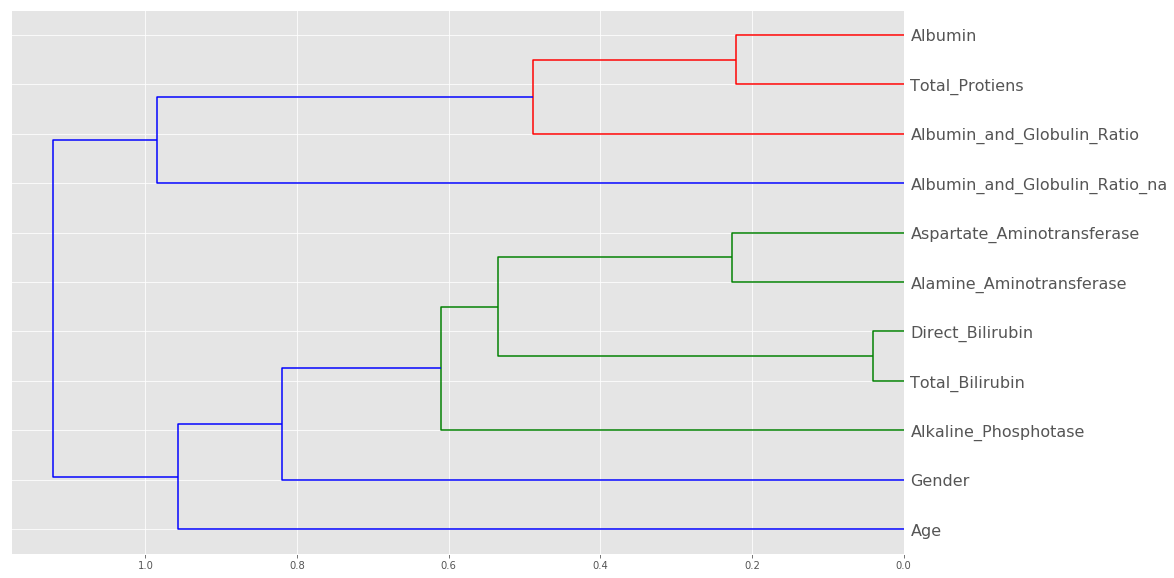

In [18]:
# Redundant Features
corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=16)
plt.show()

Strong correlation between Direct Bilirubin and Total Bilirubin, Albumin and Total_Proteins, and Aspartate_Aminotransferase and Alamine_Aminotransferase. We might be able to drop these. 

In [114]:
df_raw=pd.read_feather('tmp/liver_patient_raw')

In [115]:
df_raw.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,ill
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,ill
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,ill
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,ill
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,ill


In [116]:
# split data into training and validation sets 
idxs = get_cv_idxs(len(df), val_pct=0.25, seed=52)
mask = np.zeros(len(df), dtype=bool)
mask[idxs] = True

In [117]:
x_trn = df[~mask]
x_val = df[mask]
y_trn = y[~mask]
y_val = y[mask]

In [118]:
_, nunique_trn = np.unique(y_trn, return_counts=True)
_, nunique_val = np.unique(y_val, return_counts=True)

print(f'Training data has {nunique_trn[1]/nunique_trn.sum()} ill patients')
print(f'Validataion data has {nunique_val[1]/nunique_val.sum()} ill patients')

Training data has 0.7100456621004566 ill patients
Validataion data has 0.7241379310344828 ill patients


In [119]:
#define score report function for RF and LG
def print_score(m):
    y_trn_prob = m.predict_proba(x_trn)
    y_val_prob = m.predict_proba(x_val)
    res = [log_loss(y_trn, y_trn_prob), log_loss(y_val, y_val_prob),
          m.score(x_trn, y_trn), m.score(x_val, y_val)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print('train loss\t val loss \t train accuracy \t val accuracy')
    print(res)

## Logistic Regression <a id='LR'></a>

In [120]:
#baseline LG
mlg = LogisticRegression()
mlg.fit(x_trn, y_trn)
print_score(mlg)

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


train loss	 val loss 	 train accuracy 	 val accuracy
[0.5893139246241865, 0.595521641512092, 0.7100456621004566, 0.7241379310344828]


In [121]:
mlg.get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)>

### Hyperparameters tuning <a id='LG_hyper'></a>

In [129]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [123]:
param_dist = {'dual': [False],
              'max_iter': [100,110,120,130,140],
              'C':[1.0,1.5,2.0,2.5],
              'penalty':['l1','l2']}

In [133]:
#n_iter_search = 100
grid_search = GridSearchCV(mlg, param_grid=param_dist, cv=5, n_jobs=-1)

In [134]:
grid_search.fit(x_trn, y_trn)

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'dual': [False], 'max_iter': [100, 110, 120, 130, 140], 'C': [1.0, 1.5, 2.0, 2.5], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [135]:
grid_search.best_score_, grid_search.best_params_

(0.7009132420091324,
 {'C': 1.0, 'dual': False, 'max_iter': 100, 'penalty': 'l1'})

In [138]:
mlg = LogisticRegression(dual=False, penalty='l1', max_iter=100, C=1.0, solver='liblinear')
mlg.fit(x_trn,y_trn)
print_score(mlg)

train loss	 val loss 	 train accuracy 	 val accuracy
[0.5897232728045753, 0.5936918928961195, 0.7100456621004566, 0.7241379310344828]


### LG Feature of importance <a id='LG_feature'></a>

Feature of importance in logistic region can be accessed by a .coef_ attribute. 

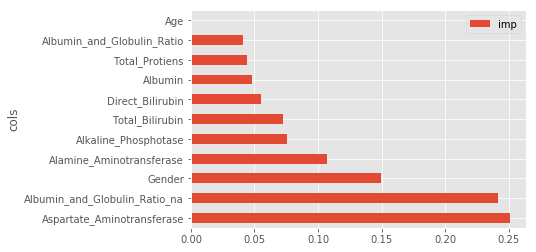

In [151]:
fi_lg = pd.DataFrame({'cols': x_trn.columns, 'imp':np.abs(mlg.coef_[0])})
fi_lg = fi_lg.sort_values('imp', ascending=False)
fi_lg.plot('cols','imp',kind='barh')

Strangely, the logistic regression considers Age not important and Albumin_and_Globulin_Ratio_na as important. [Random forest model](#https://github.com/worasom/indian_liver_patients/blob/master/Indian_liver_patients_random_forest.ipynb) does the opposite. I hope to compare this with a custom permulation-based feature of importance function.

In [158]:
to_keep_lg = fi_lg[fi_lg.imp>0.05].cols
print(to_keep_lg)

6        Aspartate_Aminotransferase
10    Albumin_and_Globulin_Ratio_na
1                            Gender
5          Alamine_Aminotransferase
4              Alkaline_Phosphotase
2                   Total_Bilirubin
3                  Direct_Bilirubin
Name: cols, dtype: object


In [165]:
# custom made feature of importance
def feat_importance(m, x_trn, y_trn, metric=accuracy_score):
    """ Computes the feature importance for any model
    m is the model
    x_trn is the training data
    metric is the accuracy_score
    """
    baseline = metric(y_trn, m.predict(x_trn))
    imp = []
    imp_std = []
    for col in x_trn.columns:
        tempt = x_trn.copy()
        shuffle = []
        # ten iteration to get better statistic
        for i in range(10):
            tempt[col] = np.random.RandomState(seed=42).permutation(tempt[col])
            shuffle_score = metric(y_trn, m.predict(tempt))
            shuffle.append((baseline - shuffle_score)/baseline*100)
        imp.append(np.maximum(0,np.mean(shuffle)))
        imp_std.append(np.std(shuffle))
    fea_imp = pd.DataFrame({'cols': x_trn.columns, 'imp':imp,'imp_std':imp_std})
    return fea_imp.sort_values('imp', ascending=False)

In [166]:
# use fastai command to calculate feature of importance
fi_per = feat_importance(mlg, x_trn, y_trn, accuracy_score)
fi_per

,cols,imp,imp_std
5,Alamine_Aminotransferase,0.289389,0.442049
6,Aspartate_Aminotransferase,0.289389,0.225080
3,Direct_Bilirubin,0.128617,0.157523
1,Gender,0.096463,0.289389
2,Total_Bilirubin,0.032154,0.225080
9,Albumin_and_Globulin_Ratio,0.032154,0.096463
10,Albumin_and_Globulin_Ratio_na,0.032154,0.096463
0,Age,0.000000,0.000000
4,Alkaline_Phosphotase,0.000000,0.143799
7,Total_Protiens,0.000000,0.173156


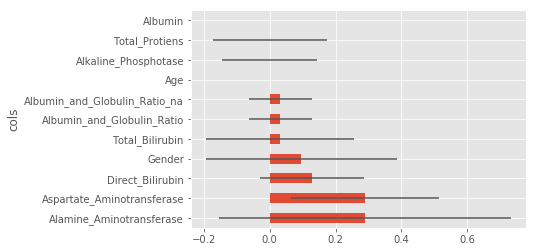

In [167]:
fi_per.plot('cols', 'imp', 'barh', xerr='imp_std', legend=False)

In [175]:
to_keep_per = fi_per[fi_per.imp>0.0].cols
print(to_keep_per)

5          Alamine_Aminotransferase
6        Aspartate_Aminotransferase
3                  Direct_Bilirubin
1                            Gender
2                   Total_Bilirubin
9        Albumin_and_Globulin_Ratio
10    Albumin_and_Globulin_Ratio_na
Name: cols, dtype: object


Compare the performance of the models with the features described by lg.coef_ and permulted feature of importance

In [171]:
df_keep = df[to_keep_lg].copy()
x_trn = df_keep[~mask]
x_val = df_keep[mask]

In [172]:
mlg.fit(x_trn,y_trn)
print_score(mlg)

train loss	 val loss 	 train accuracy 	 val accuracy
[0.5906110523058948, 0.5922687185534673, 0.7100456621004566, 0.7241379310344828]


In [176]:
df_keep = df[to_keep_per].copy()
x_trn = df_keep[~mask]
x_val = df_keep[mask]

In [177]:
mlg.fit(x_trn,y_trn)
print_score(mlg)

train loss	 val loss 	 train accuracy 	 val accuracy
[0.591073474891272, 0.5961530363106693, 0.7100456621004566, 0.7172413793103448]


Using coef_ actually give better result. We will look at features which are related and see if droping one of those could improve the model. 

Strong correlation between Direct Bilirubin and Total Bilirubin, Albumin and Total_Proteins, and Aspartate_Aminotransferase and Alamine_Aminotransferase. We might be able to drop these. 

In [183]:
df_keep = df[to_keep_lg].copy()
x_trn = df_keep[~mask]
x_val = df_keep[mask]
mlg.fit(x_trn, y_trn)
mlg.score(x_trn, y_trn)

0.7100456621004566

In [179]:
x_trn.columns

Index(['Aspartate_Aminotransferase', 'Albumin_and_Globulin_Ratio_na', 'Gender',
       'Alamine_Aminotransferase', 'Alkaline_Phosphotase', 'Total_Bilirubin',
       'Direct_Bilirubin'],
      dtype='object')

In [186]:
def get_oob(df_keep):
    
    mlg.fit(x_trn, y_trn)
    return mlg.score(x_val, y_val)

In [187]:
for drop_fea in ('Total_Bilirubin', 'Direct_Bilirubin', 
                 'Aspartate_Aminotransferase', 'Alamine_Aminotransferase'):
    print(drop_fea, get_oob(x_trn.drop(drop_fea, axis=1)))

Total_Bilirubin 0.7241379310344828
Direct_Bilirubin 0.7241379310344828
Aspartate_Aminotransferase 0.7241379310344828
Alamine_Aminotransferase 0.7241379310344828


### Analyzing LG Results <a id='LG_result'></a>

In [192]:
y_preds = mlg.predict(x_val)
y__proba = mlg.predict_proba(x_val)

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Classification Report validation set: 
               precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00        40
         Ill       0.72      1.00      0.84       105

   micro avg       0.72      0.72      0.72       145
   macro avg       0.36      0.50      0.42       145
weighted avg       0.52      0.72      0.61       145



([<matplotlib.axis.YTick at 0x1629964e748>,
 <a list of 2 Text yticklabel objects>)

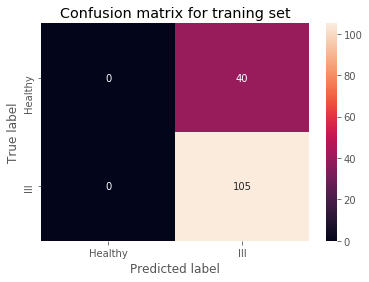

In [193]:
#print('Confusion Matrix: \n', confusion_matrix(y_val,preds))
print('Classification Report validation set: \n', classification_report(y_val,y_preds, 
                                                        target_names=['Healthy', 'Ill']))

sns.heatmap(confusion_matrix(y_val,y_preds),annot=True,fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for traning set')
tick_marks = np.arange(2) + 0.5
plt.xticks(tick_marks, ['Healthy','Ill'])
plt.yticks(tick_marks, ['Healthy','Ill'])

In [194]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val, y_preds)

0.5

## Conclusions <a id='con'></a>

Logistic regression achieved 71% accuracy. Features included in the models are 'Aspartate_Aminotransferase', 'Albumin_and_Globulin_Ratio_na', 'Gender',
'Alamine_Aminotransferase', 'Alkaline_Phosphotase', 'Total_Bilirubin',
'Direct_Bilirubin'. The logistic regression and random forest has large false positive.

In the future, I will use neural network for this task and compare the results.